In [ ]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install visualkeras


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, Add, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
def load_preprocess_image(img_path):
    img = load_img(img_path, color_mode='grayscale', target_size=(256, 256))
    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img

def load_preprocess_mask(mask_path):
    mask = load_img(mask_path, color_mode='grayscale', target_size=(256, 256))
    mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]
    return mask

def load_dataset(image_dir, mask_dir):
    X = []
    y = []
    for img_name in os.listdir(image_dir):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(image_dir, img_name)
            # Assuming the mask file name convention is imagename_m.png
            mask_name = img_name.split('.')[0] + '_m.jpg'
            mask_path = os.path.join(mask_dir, mask_name)

            if os.path.exists(mask_path):  # Ensure mask file exists
                img = load_preprocess_image(img_path)
                mask = load_preprocess_mask(mask_path)
                X.append(img)
                y.append(mask)
            else:
                print(f"Mask file not found for image: {img_name}")
    X = np.array(X)
    y = np.array(y)
    return X, y


In [ ]:
# Directory paths for dataset
image_dir = 'F:/Surajit Das/Dataset/Brain Tumor Segmentation Dataset 1/Brain Tumor Segmentation Dataset 1/image'
mask_dir = 'F:/Surajit Das/Dataset/Brain Tumor Segmentation Dataset 1/Brain Tumor Segmentation Dataset 1/mask'

# Load dataset
X, y = load_dataset(image_dir, mask_dir)

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Attention block
def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(g)
    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, kernel_size=1, strides=1, padding='same')(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = multiply([x, rate])
    return att_x

# Residual block with 1x1 convolution to match dimensions
def residual_block(x, filters):
    res = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    res = Activation('relu')(res)
    res = Conv2D(filters, kernel_size=3, strides=1, padding='same')(res)

    # 1x1 convolution to match the dimensions of res
    x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)

    res = Add()([res, x])
    res = Activation('relu')(res)
    return res

def unet_attention_residual(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = residual_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = residual_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = residual_block(pool4, 1024)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    att6 = attention_block(conv4, up6, 512)
    merge6 = concatenate([att6, up6], axis=3)
    conv6 = residual_block(merge6, 512)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    att7 = attention_block(conv3, up7, 256)
    merge7 = concatenate([att7, up7], axis=3)
    conv7 = residual_block(merge7, 256)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    att8 = attention_block(conv2, up8, 128)
    merge8 = concatenate([att8, up8], axis=3)
    conv8 = residual_block(merge8, 128)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    att9 = attention_block(conv1, up9, 64)
    merge9 = concatenate([att9, up9], axis=3)
    conv9 = residual_block(merge9, 64)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
batch_size = 16
epochs = 50

model = unet_attention_residual(input_size=(256, 256, 1))

# Optionally, define callbacks like model checkpoint and early stopping
# checkpoint = ModelCheckpoint(filepath='model_best_weights.h5', save_best_only=True, verbose=1)
# early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    # callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 653s 13s/step - accuracy: 0.8841 - loss: 0.3951 - val_accuracy: 0.9750 - val_loss: 0.0819
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 632s 13s/step - accuracy: 0.9752 - loss: 0.0788 - val_accuracy: 0.9750 - val_loss: 0.0784
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 635s 13s/step - accuracy: 0.9755 - loss: 0.0677 - val_accuracy: 0.9750 - val_loss: 0.0565
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 656s 13s/step - accuracy: 0.9762 - loss: 0.0534 - val_accuracy: 0.9750 - val_loss: 0.0457
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 845s 17s/step - accuracy: 0.9802 - loss: 0.0431 - val_accuracy: 0.9856 - val_loss: 0.0315
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1277s 25s/step - accuracy: 0.9850 - loss: 0.0342 - val_accuracy: 0.9838 - val_loss: 0.0363
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1178s 23s/step - accuracy: 0.9855 - loss: 0.0323 - val_accuracy: 0.9884 - val_loss: 0.0245
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 695s 14s/step - accuracy: 0.9887 - loss: 0.0236 - val_accuracy: 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)

# Make predictions (example)
predictions = model.predict(X_val)


7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.9931 - loss: 0.0095
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step


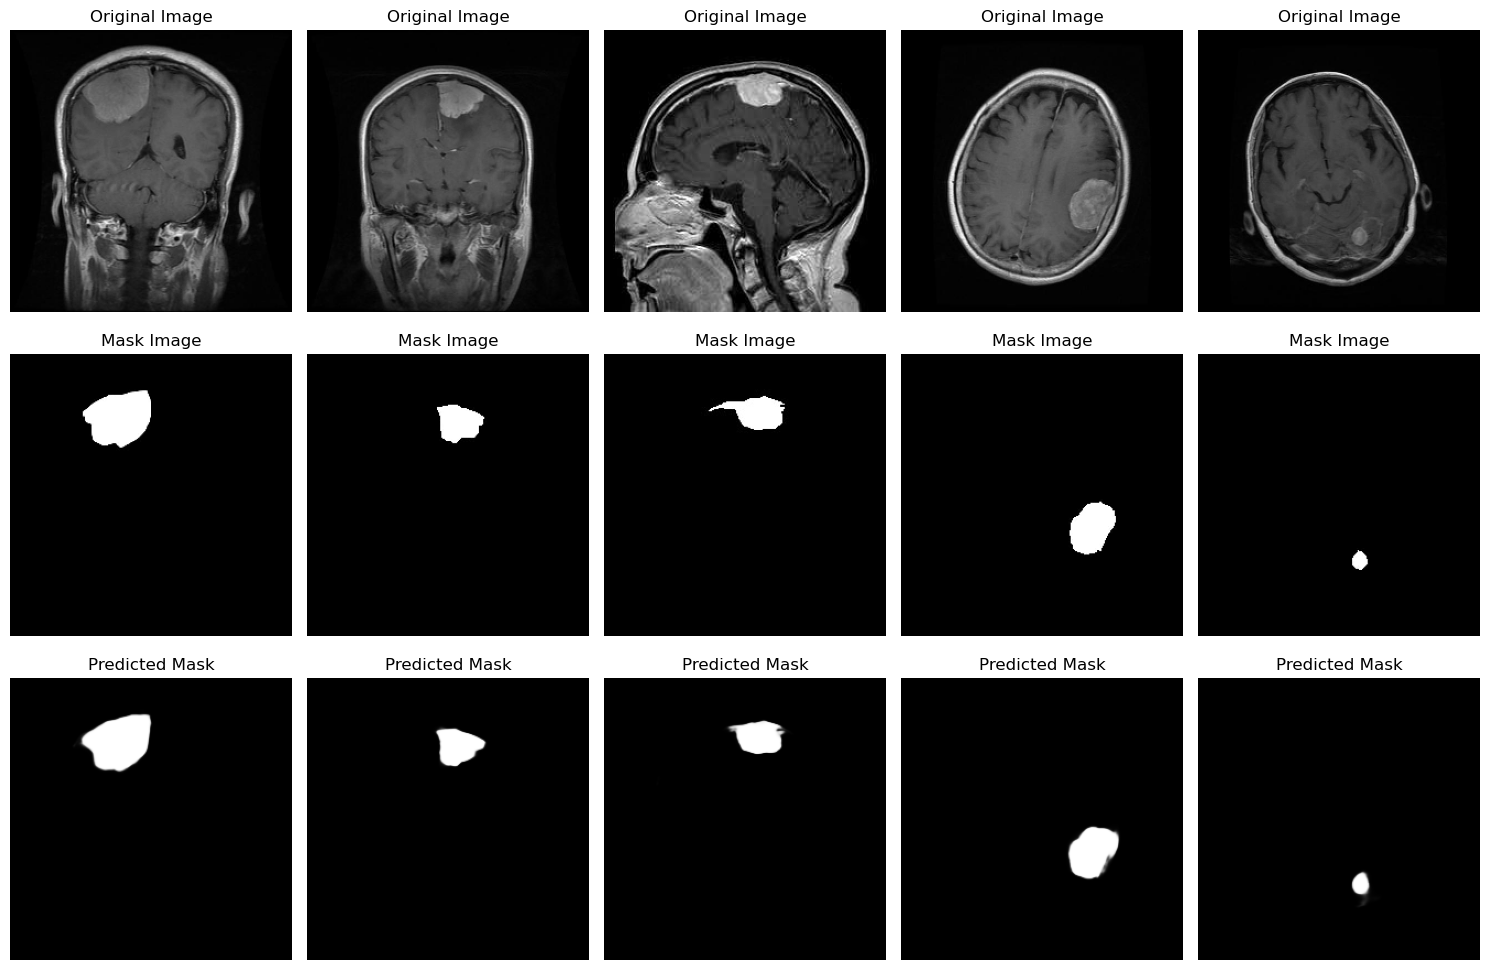

In [ ]:
import matplotlib.pyplot as plt

# Assuming X_test and y_test are your test set images and masks
# Predict on the test set
predictions = model.predict(X_val)

# Adjusting figure size
plt.figure(figsize=(15, 10))

# Loop through some examples
for i in range(5):  # Adjust the range as needed
    # Original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_val[i].reshape(256, 256), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Mask image
    plt.subplot(3, 5, i + 6)
    plt.imshow(y_val[i].reshape(256, 256), cmap='gray')
    plt.title('Mask Image')
    plt.axis('off')

    # Model's prediction
    plt.subplot(3, 5, i + 11)
    plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Directory paths for dataset
image_dir = 'F:/Surajit Das/Dataset/Brain Tumor Segmentation Dataset 1/Brain Tumor Segmentation Dataset 1/image'
mask_dir = 'F:/Surajit Das/Dataset/Brain Tumor Segmentation Dataset 1/Brain Tumor Segmentation Dataset 1/mask'

# Load dataset
X, y = load_dataset(image_dir, mask_dir)

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step


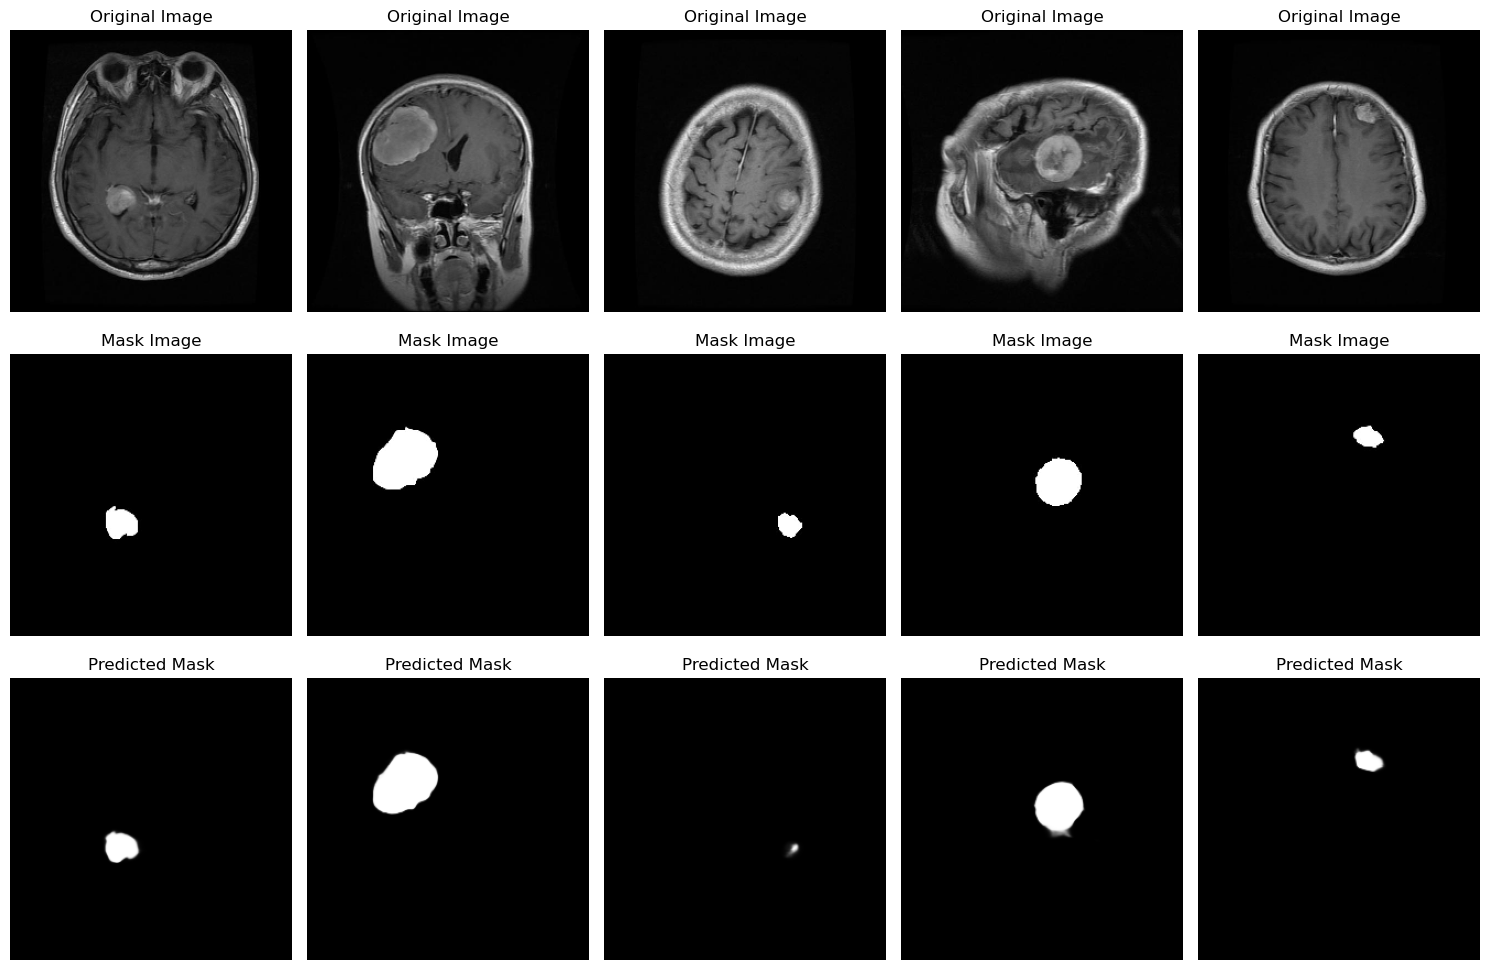

In [ ]:
import matplotlib.pyplot as plt

# Predict on the test set
predictions = model.predict(X_test)

# Adjusting figure size
plt.figure(figsize=(15, 10))

# Loop through some examples
for i in range(5):  # Adjust the range as needed
    # Original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[i].reshape(256, 256), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Mask image
    plt.subplot(3, 5, i + 6)
    plt.imshow(y_test[i].reshape(256, 256), cmap='gray')
    plt.title('Mask Image')
    plt.axis('off')

    # Model's prediction
    plt.subplot(3, 5, i + 11)
    plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


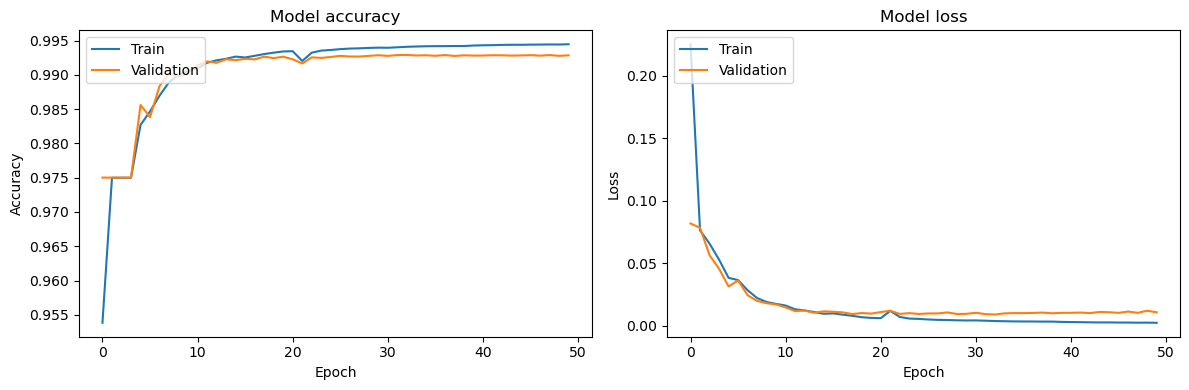

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Test Loss: 0.010319149121642113
Test Accuracy: 0.9927392601966858


5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step


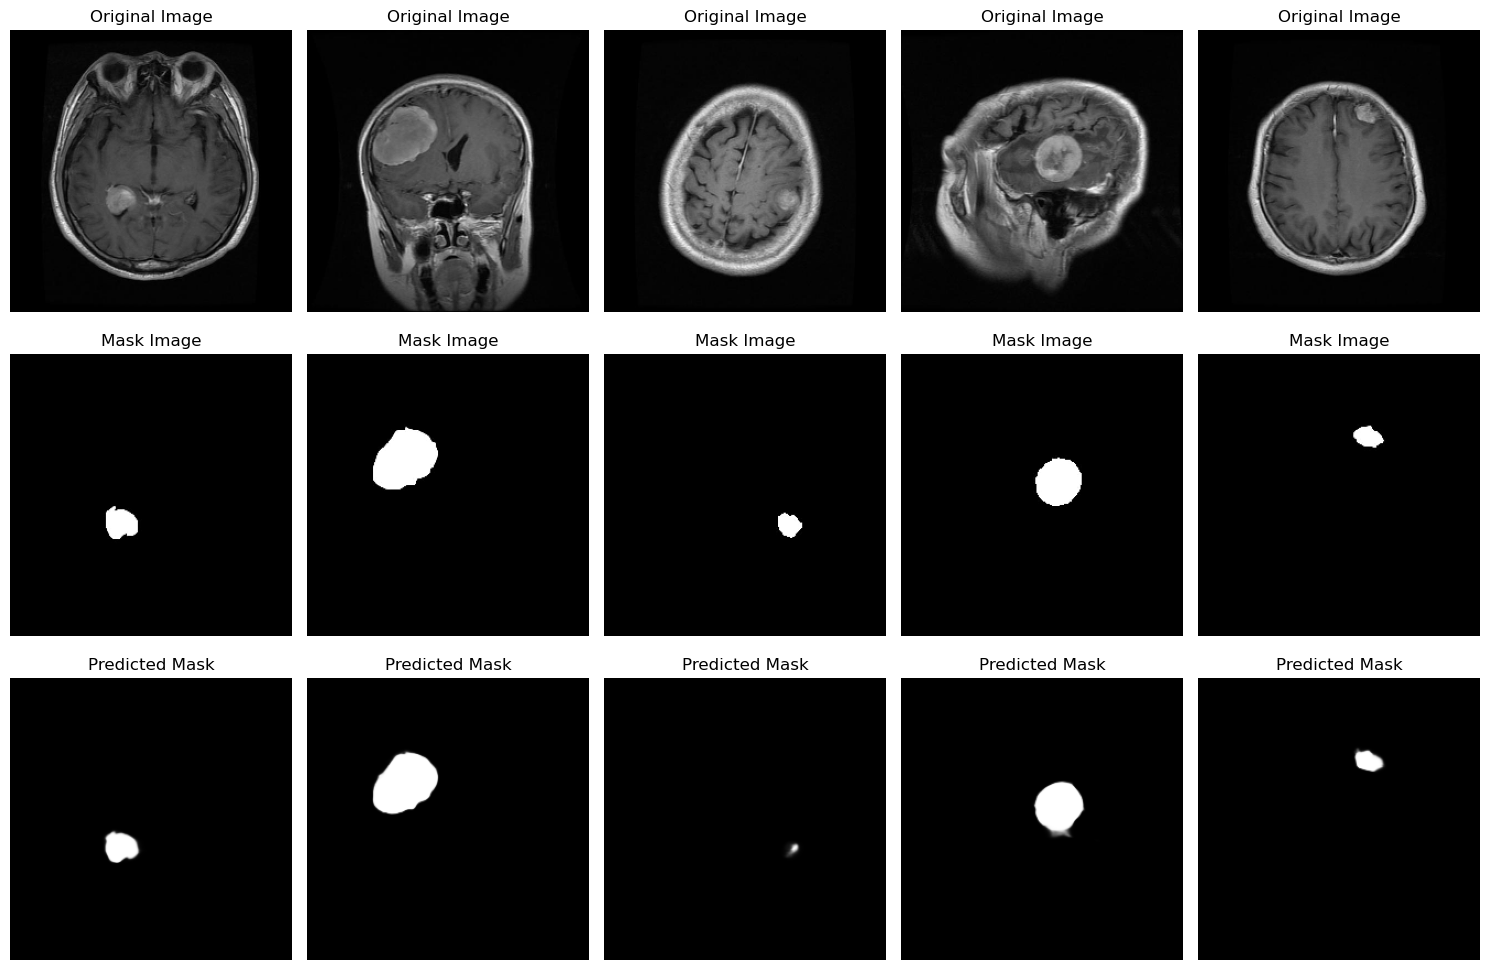

In [ ]:
import matplotlib.pyplot as plt

# Predict on the test set
predictions = model.predict(X_test)

# Adjusting figure size
plt.figure(figsize=(15, 10))

# Loop through some examples
for i in range(5):  # Adjust the range as needed
    # Original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[i].reshape(256, 256), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Mask image
    plt.subplot(3, 5, i + 6)
    plt.imshow(y_test[i].reshape(256, 256), cmap='gray')
    plt.title('Mask Image')
    plt.axis('off')

    # Model's prediction
    plt.subplot(3, 5, i + 11)
    plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step


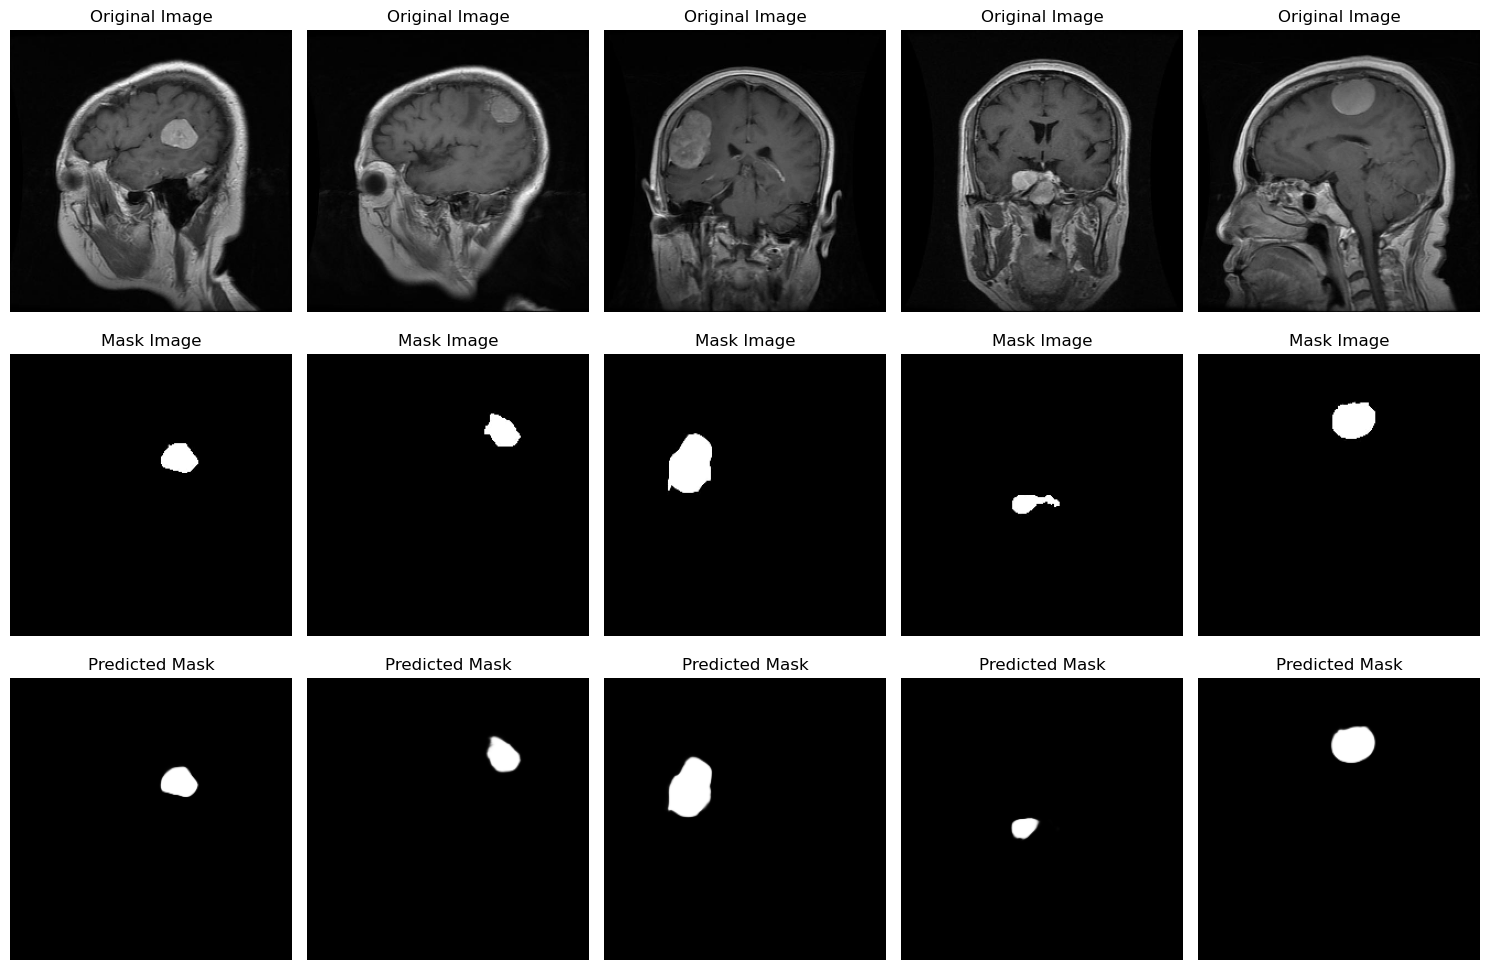

In [ ]:
import matplotlib.pyplot as plt

# Assuming X_test and y_test are your test set images and masks
# Predict on the test set
predictions = model.predict(X_val)

# Adjusting figure size
plt.figure(figsize=(15, 10))

# Loop through some examples
for i in range(5):  # Adjust the range as needed
    # Original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_val[i].reshape(256, 256), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Mask image
    plt.subplot(3, 5, i + 6)
    plt.imshow(y_val[i].reshape(256, 256), cmap='gray')
    plt.title('Mask Image')
    plt.axis('off')

    # Model's prediction
    plt.subplot(3, 5, i + 11)
    plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save model
model.save('my_model_unet1.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load model
model = load_model('my_model_unet1.keras')

5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step


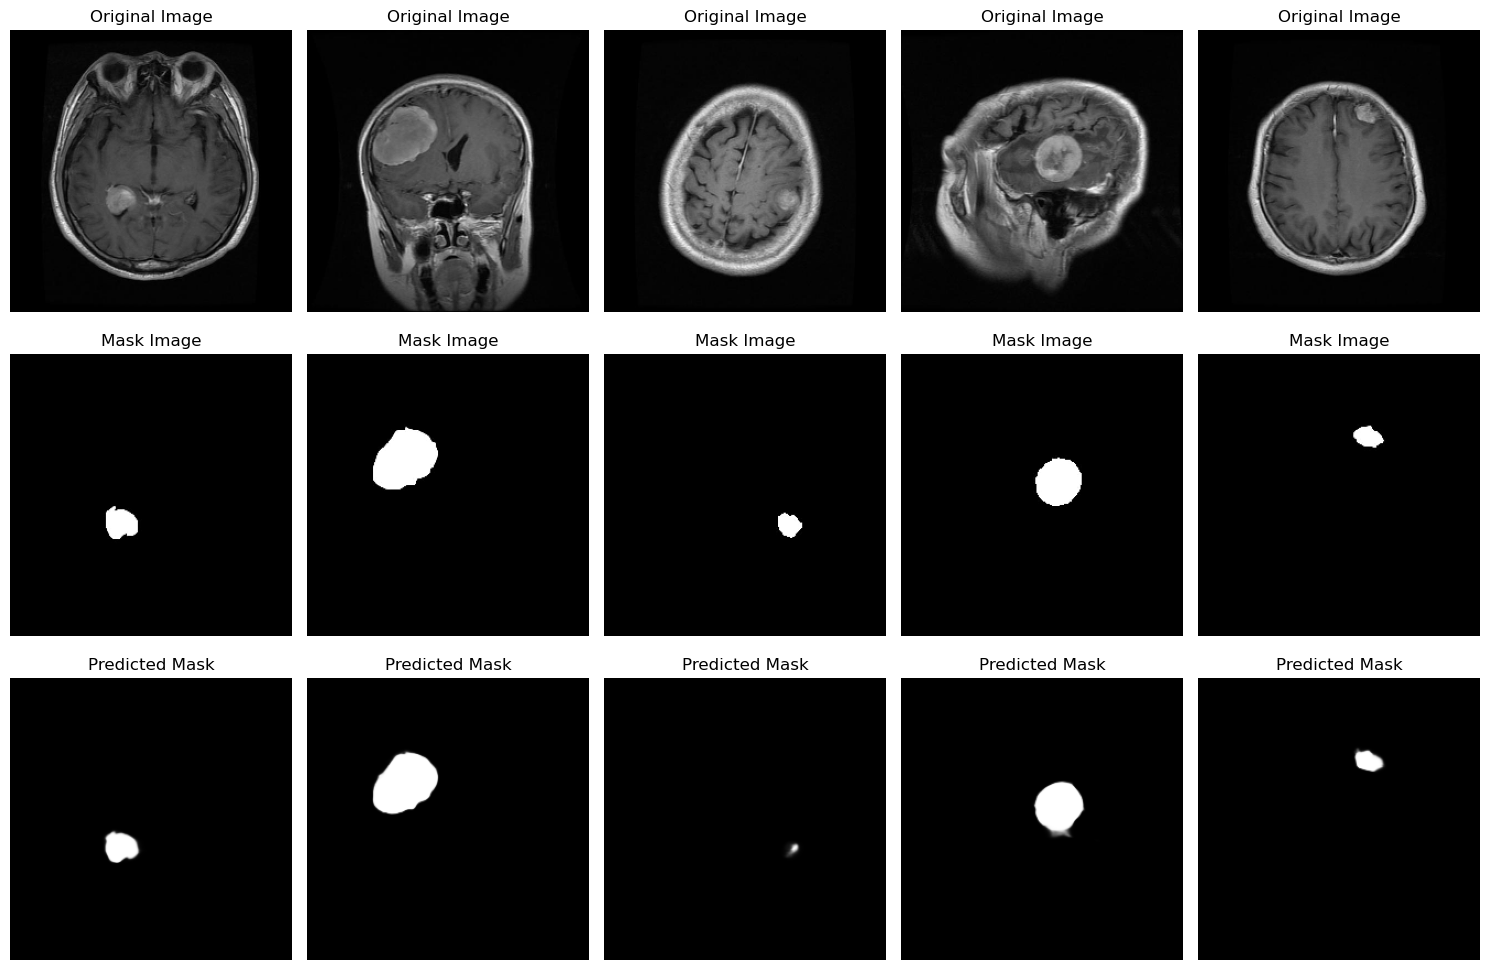

In [ ]:
import matplotlib.pyplot as plt

# Predict on the test set
predictions = model.predict(X_test)

# Adjusting figure size
plt.figure(figsize=(15, 10))

# Loop through some examples
for i in range(5):  # Adjust the range as needed
    # Original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[i].reshape(256, 256), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Mask image
    plt.subplot(3, 5, i + 6)
    plt.imshow(y_test[i].reshape(256, 256), cmap='gray')
    plt.title('Mask Image')
    plt.axis('off')

    # Model's prediction
    plt.subplot(3, 5, i + 11)
    plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

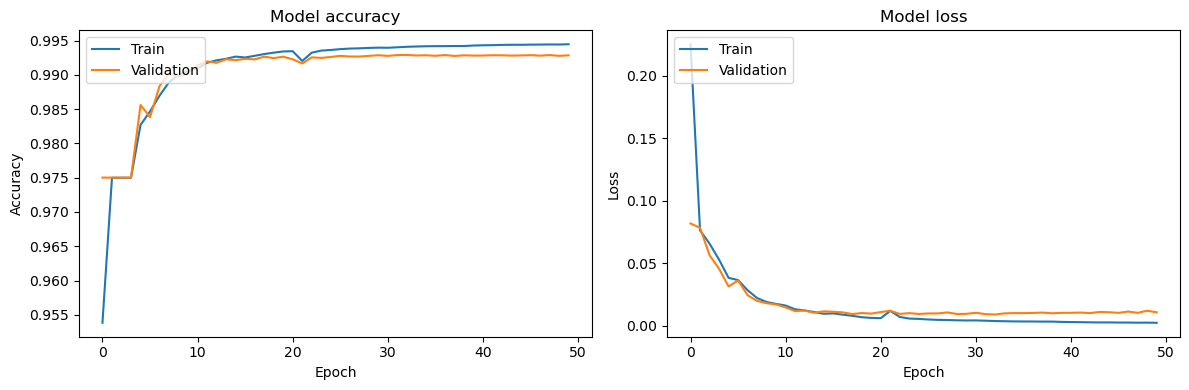

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Dice Score Function
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
# Extracting the training history
history_dict = history.history

# Finding the epoch with the maximum training accuracy
max_train_acc_epoch = history_dict['accuracy'].index(max(history_dict['accuracy'])) + 1
max_train_acc = max(history_dict['accuracy'])

# Finding the epoch with the maximum validation accuracy
max_val_acc_epoch = history_dict['val_accuracy'].index(max(history_dict['val_accuracy'])) + 1
max_val_acc = max(history_dict['val_accuracy'])

# Finding the epoch with the minimum training loss
min_train_loss_epoch = history_dict['loss'].index(min(history_dict['loss'])) + 1
min_train_loss = min(history_dict['loss'])

# Finding the epoch with the minimum validation loss
min_val_loss_epoch = history_dict['val_loss'].index(min(history_dict['val_loss'])) + 1
min_val_loss = min(history_dict['val_loss'])

# Printing the results
print(f"Maximum Training Accuracy: {max_train_acc:.4f} at epoch {max_train_acc_epoch}")
print(f"Maximum Validation Accuracy: {max_val_acc:.4f} at epoch {max_val_acc_epoch}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at epoch {min_train_loss_epoch}")
print(f"Minimum Validation Loss: {min_val_loss:.4f} at epoch {min_val_loss_epoch}")


Maximum Training Accuracy: 0.9945 at epoch 50
Maximum Validation Accuracy: 0.9929 at epoch 33
Minimum Training Loss: 0.0025 at epoch 50
Minimum Validation Loss: 0.0092 at epoch 33


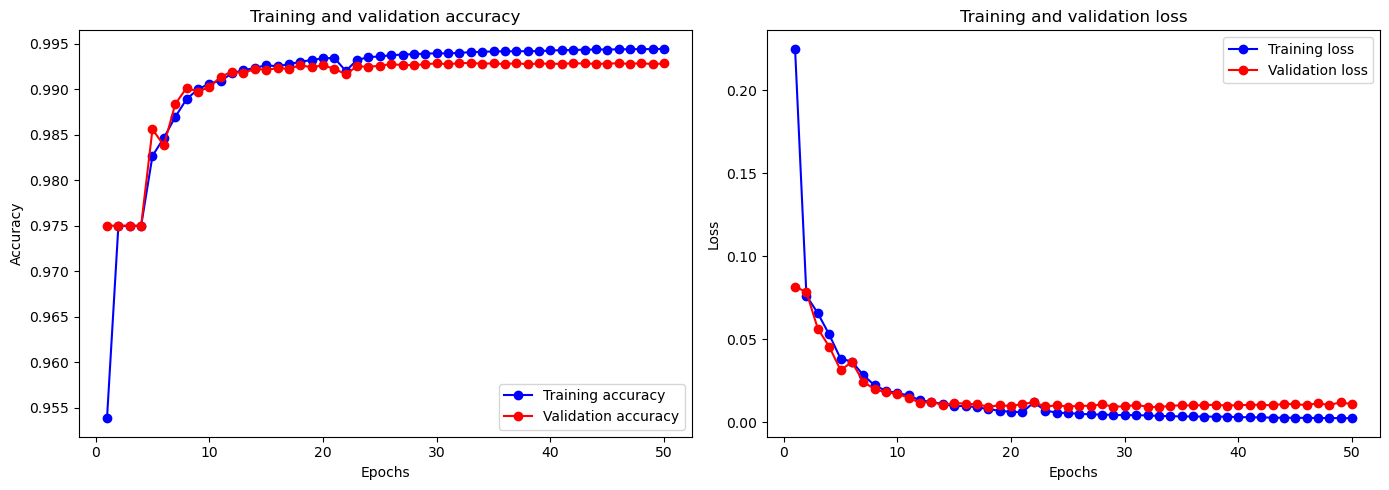

In [ ]:
import matplotlib.pyplot as plt

# Extracting the training history
history_dict = history.history

# Values for plotting
epochs = range(1, len(history_dict['accuracy']) + 1)
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\rajat\AppData\Local\Temp\ipykernel_8556\2837037794.py:71: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


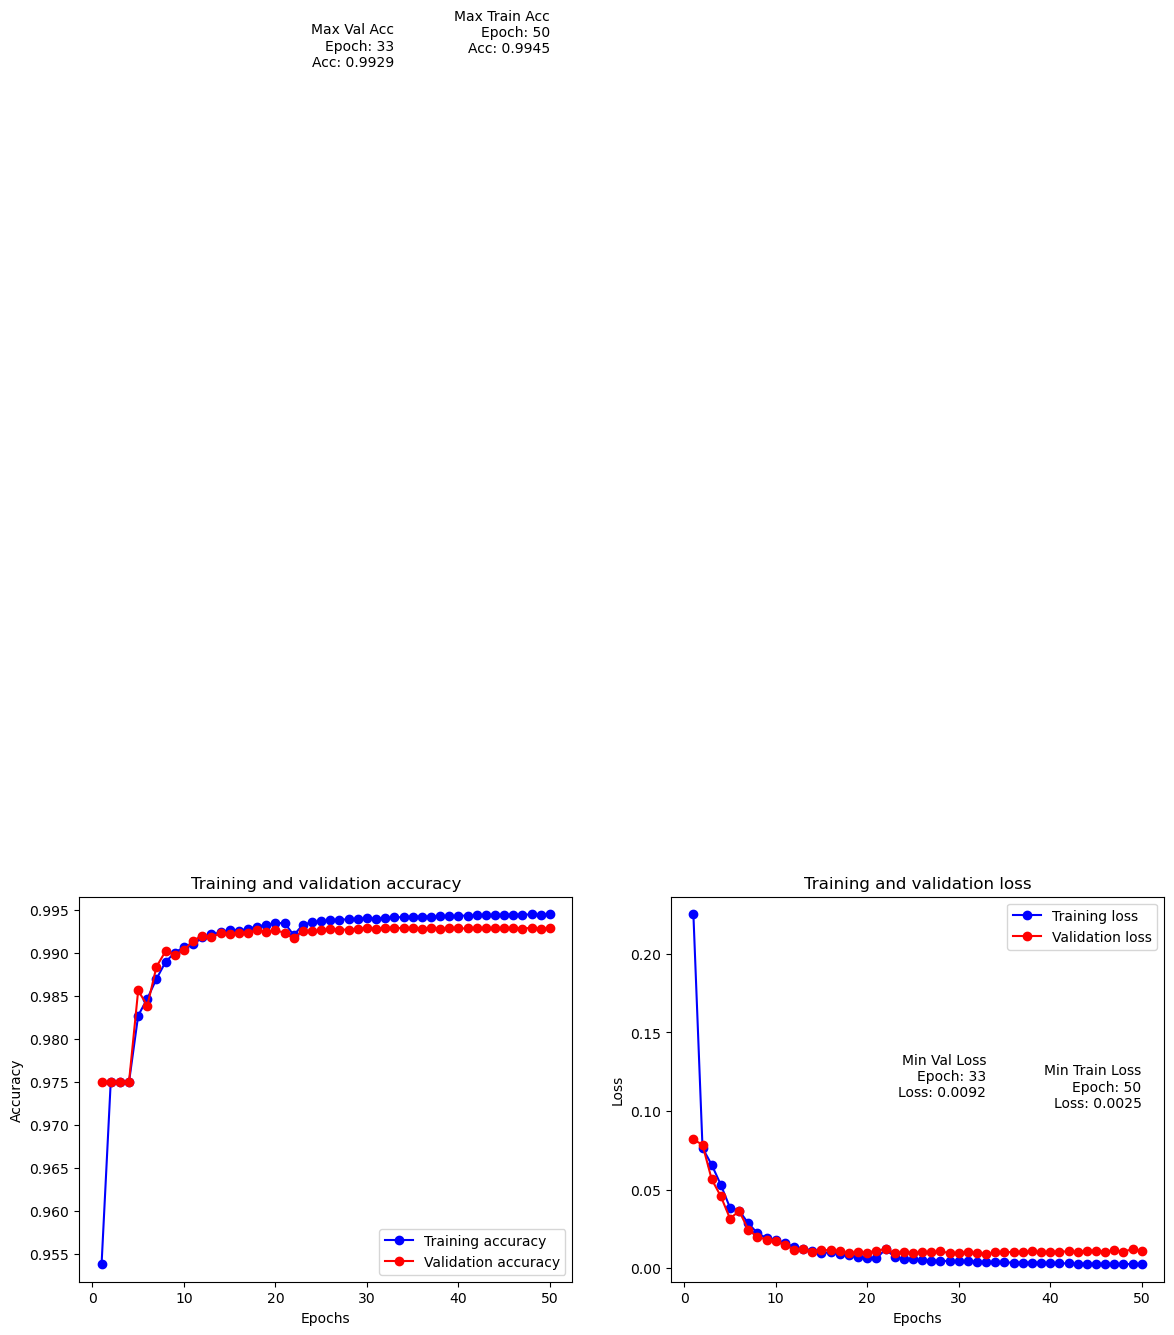

In [ ]:
import matplotlib.pyplot as plt

# Extracting the training history
history_dict = history.history

# Values for plotting
epochs = range(1, len(history_dict['accuracy']) + 1)
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Finding the epoch with the maximum training accuracy
max_train_acc_epoch = history_dict['accuracy'].index(max(history_dict['accuracy'])) + 1
max_train_acc = max(history_dict['accuracy'])

# Finding the epoch with the maximum validation accuracy
max_val_acc_epoch = history_dict['val_accuracy'].index(max(history_dict['val_accuracy'])) + 1
max_val_acc = max(history_dict['val_accuracy'])

# Finding the epoch with the minimum training loss
min_train_loss_epoch = history_dict['loss'].index(min(history_dict['loss'])) + 1
min_train_loss = min(history_dict['loss'])

# Finding the epoch with the minimum validation loss
min_val_loss_epoch = history_dict['val_loss'].index(min(history_dict['val_loss'])) + 1
min_val_loss = min(history_dict['val_loss'])

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Annotating the maximum accuracy points without arrows
plt.annotate(f'Max Train Acc\nEpoch: {max_train_acc_epoch}\nAcc: {max_train_acc:.4f}',
             xy=(max_train_acc_epoch, max_train_acc),
             xytext=(max_train_acc_epoch, max_train_acc + 0.1),
             horizontalalignment='right')

plt.annotate(f'Max Val Acc\nEpoch: {max_val_acc_epoch}\nAcc: {max_val_acc:.4f}',
             xy=(max_val_acc_epoch, max_val_acc),
             xytext=(max_val_acc_epoch, max_val_acc + 0.1),
             horizontalalignment='right')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Annotating the minimum loss points without arrows
plt.annotate(f'Min Train Loss\nEpoch: {min_train_loss_epoch}\nLoss: {min_train_loss:.4f}',
             xy=(min_train_loss_epoch, min_train_loss),
             xytext=(min_train_loss_epoch, min_train_loss + 0.1),
             horizontalalignment='right')

plt.annotate(f'Min Val Loss\nEpoch: {min_val_loss_epoch}\nLoss: {min_val_loss:.4f}',
             xy=(min_val_loss_epoch, min_val_loss),
             xytext=(min_val_loss_epoch, min_val_loss + 0.1),
             horizontalalignment='right')

plt.tight_layout()
plt.show()


In [ ]:
# Assuming your trained model is stored in the variable `model`
# and your test data is stored in `X_test` and `y_test`

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the test accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.9927
Test Loss: 0.0103


In [ ]:
from sklearn.metrics import classification_report

# Assuming your trained model is stored in the variable `model`
# and your test data is stored in `X_test` and `y_test`

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Flatten the arrays
y_test_flat = y_test.flatten().astype(int)
y_pred_flat = y_pred.flatten().astype(int)

# Calculate precision, recall, and F1-score
print(classification_report(y_test_flat, y_pred_flat))

5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   9632081
           1       0.87      0.94      0.90    198319

    accuracy                           1.00   9830400
   macro avg       0.93      0.97      0.95   9830400
weighted avg       1.00      1.00      1.00   9830400



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   9632081
           1       0.87      0.94      0.90    198319

    accuracy                           1.00   9830400
   macro avg       0.93      0.97      0.95   9830400
weighted avg       1.00      1.00      1.00   9830400



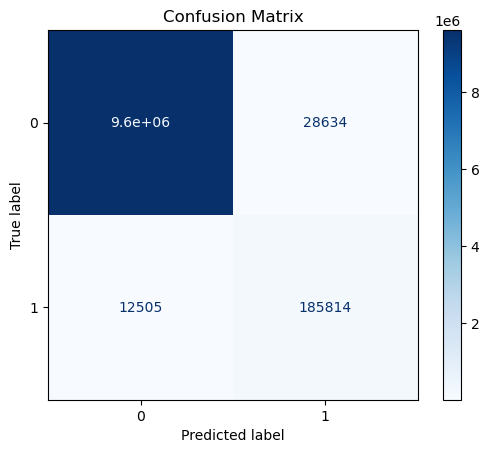

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Flatten the arrays
y_test_flat = y_test.flatten().astype(int)
y_pred_flat = y_pred.flatten().astype(int)

# Calculate precision, recall, and F1-score
print(classification_report(y_test_flat, y_pred_flat))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step


<Figure size 800x600 with 0 Axes>

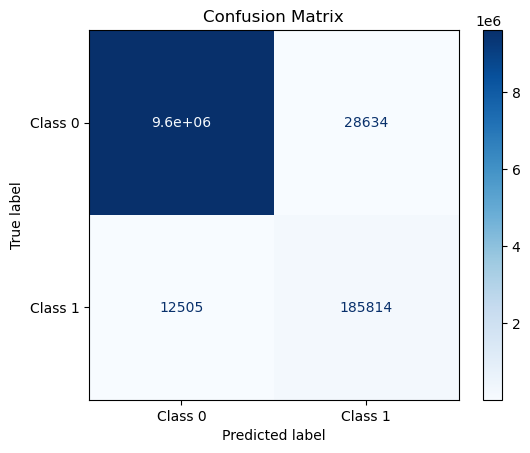

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming your trained model is stored in the variable `model`
# and your test data is stored in `X_test` and `y_test`

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Flatten the arrays
y_test_flat = y_test.flatten().astype(int)
y_pred_flat = y_pred.flatten().astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
